## Prueba 1 Modelo de Red Neuronal Sencillo

Vamos a comenzar por un modelo de red neuronal sencillo. Vamos primero a obviar el hecho de que están desbalanceadas las clases. Vamos a reportar f1 score para intentar solucionar el problema del desbalanceado.


En todos los casos que probemos vamos a utilizar oversampling y undersampling para comparar

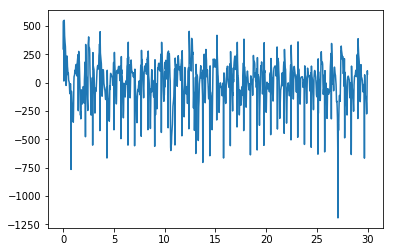

In [1]:
#load data
#load data
%matplotlib inline
import matplotlib.pyplot as plt

#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#Decimamos

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

fs = 300. #hz
t = np.arange(len(X_train[0]))/fs
plt.plot(t,X_train[0,:])


#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal

decimate = False

if decimate:
    freq = fs/10#Hz
    print(freq)
    secs = len(X_train[200])/fs
    samps = int(secs*freq)
    c = 0
    X_new = np.zeros((X_train.shape[0],samps))
    X_new_test = np.zeros((X_test.shape[0],samps))
    for x,x_test in zip(X_train,X_test):
        X_new[c,:] = signal.decimate(x,10,ftype = 'fir')
        X_new_test[c,:] = signal.decimate(x_test,10,ftype = 'fir')
    
        c += 1
    
    t = np.arange(len(X_new[200]))/freq
    plt.plot(t,X_new[200,:])
    print(len(X_new[0]))

    X_train = X_new.copy()
    X_test = X_new_test.copy()

## Preprocesamos los datos

In [2]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)

/home/obarquero/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Under sampling y over sampling

Siempre sobre datos de entrada normalizados

In [3]:
#Vamos a probar balanceando con under sampling y over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


## Diseño red neuronal

In [4]:
#función para crear un modelo de un número determinado de capas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import initializers
from keras.layers.normalization import BatchNormalization
import keras


#f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model(N,n_hidd = [2,2,2], p = 0):
    """
    Modelo de red neuronal. 
    
    N: number of input featurs
    n_hidd indica la arquitectura del modelo: n_cols = número de capas, value for eahc col, the number of hidden
    units
    """
    
    model = Sequential()
    
    #input layer
    model.add(Dense(n_hidd[0],input_dim = N,activation = 'relu'))
    model.add(BatchNormalization())
    
    #hidden layers
    for n_h in n_hidd[1:]:
        model.add(Dense(n_h,activation='relu',kernel_initializer=initializers.he_normal(seed=None)))
        model.add(BatchNormalization())
        model.add(Dropout(p))
        
    #output layer
    model.add(Dense(4,activation = 'softmax'))
   

    opt =keras.optimizers.Adam(lr = 4e-3)
    #compile model
    model.compile(loss='categorical_crossentropy',optimizer = opt,metrics = ['accuracy',f1])
    return model

/home/obarquero/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Datos normalizados sin balancear

In [5]:
#Split data into dev and trin
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

#WARNING que volvemos a llamar train
for train, dev in skf.split(X_train_n,y_train):
    X_train, X_dev = X_train_n[train], X_train_n[dev]
    y_train, y_dev = y_train[train], y_train[dev]
    
print(X_train.shape)
print(X_dev.shape)

(3824, 9000)
(957, 9000)


In [6]:
#Entrenamos el modelo 

N = X_train.shape[1]#number of features
#n_h = [400,800,1200]
n_h = [int(N/2),int(N/4),int(N/8),int(N/16),int(N/32)]
print(n_h)
print(N)
prob_dropout = 0.8
model = KerasClassifier(build_fn = create_model,N=N, n_hidd=n_h,p = prob_dropout,epochs = 1500, batch_size = 100, verbose = 1)

history = model.fit(X_train,y_train)

[4500, 2250, 1125, 562, 281]
9000
Epoch 1/1500
3824/3824 [==============================] - 92s 24ms/step - loss: 2.3571 - acc: 0.3572 - f1: 0.3360
Epoch 2/1500
3824/3824 [==============================] - 89s 23ms/step - loss: 1.3791 - acc: 0.4987 - f1: 0.4467
Epoch 3/1500
3824/3824 [==============================] - 91s 24ms/step - loss: 1.1715 - acc: 0.5578 - f1: 0.4957
Epoch 4/1500
3824/3824 [==============================] - 92s 24ms/step - loss: 1.1314 - acc: 0.5659 - f1: 0.5149
Epoch 5/1500
3824/3824 [==============================] - 88s 23ms/step - loss: 1.1155 - acc: 0.5703 - f1: 0.5198
Epoch 6/1500
3824/3824 [==============================] - 87s 23ms/step - loss: 1.0986 - acc: 0.5758 - f1: 0.5422
Epoch 7/1500
3824/3824 [==============================] - 88s 23ms/step - loss: 1.0708 - acc: 0.5819 - f1: 0.5429
Epoch 8/1500
3824/3824 [==============================] - 87s 23ms/step - loss: 1.0540 - acc: 0.5834 - f1: 0.5463
Epoch 9/1500
3824/3824 [==============================

3824/3824 [==============================] - 70s 18ms/step - loss: 0.0679 - acc: 0.9804 - f1: 0.9813
Epoch 73/1500
3824/3824 [==============================] - 69s 18ms/step - loss: 0.0703 - acc: 0.9783 - f1: 0.9780
Epoch 74/1500
3824/3824 [==============================] - 70s 18ms/step - loss: 0.0550 - acc: 0.9846 - f1: 0.9844
Epoch 75/1500
3824/3824 [==============================] - 68s 18ms/step - loss: 0.0660 - acc: 0.9786 - f1: 0.9784
Epoch 76/1500
3824/3824 [==============================] - 68s 18ms/step - loss: 0.0587 - acc: 0.9830 - f1: 0.9828
Epoch 77/1500
3824/3824 [==============================] - 69s 18ms/step - loss: 0.0496 - acc: 0.9843 - f1: 0.9838
Epoch 78/1500
3824/3824 [==============================] - 70s 18ms/step - loss: 0.0553 - acc: 0.9822 - f1: 0.9819
Epoch 79/1500
3824/3824 [==============================] - 68s 18ms/step - loss: 0.0538 - acc: 0.9833 - f1: 0.9831
Epoch 80/1500
3824/3824 [==============================] - 69s 18ms/step - loss: 0.0349 - acc:

Epoch 143/1500
3824/3824 [==============================] - 51s 13ms/step - loss: 0.1081 - acc: 0.9723 - f1: 0.9725
Epoch 144/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0628 - acc: 0.9846 - f1: 0.9844
Epoch 145/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0385 - acc: 0.9908 - f1: 0.9907
Epoch 146/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0388 - acc: 0.9906 - f1: 0.9906
Epoch 147/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0345 - acc: 0.9919 - f1: 0.9915
Epoch 148/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0412 - acc: 0.9885 - f1: 0.9884
Epoch 149/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0595 - acc: 0.9835 - f1: 0.9835
Epoch 150/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0565 - acc: 0.9843 - f1: 0.9844
Epoch 151/1500
3824/3824 [==============================] - 37s 10ms/ste

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0306 - acc: 0.9916 - f1: 0.9914
Epoch 214/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0285 - acc: 0.9911 - f1: 0.9910
Epoch 215/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0355 - acc: 0.9885 - f1: 0.9886
Epoch 216/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0258 - acc: 0.9935 - f1: 0.9933
Epoch 217/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0203 - acc: 0.9937 - f1: 0.9939
Epoch 218/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0227 - acc: 0.9937 - f1: 0.9936
Epoch 219/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0185 - acc: 0.9937 - f1: 0.9937
Epoch 220/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0320 - acc: 0.9903 - f1: 0.9903
Epoch 221/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.021

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0335 - acc: 0.9919 - f1: 0.9922
Epoch 284/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0163 - acc: 0.9953 - f1: 0.9950
Epoch 285/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0275 - acc: 0.9937 - f1: 0.9937
Epoch 286/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0331 - acc: 0.9906 - f1: 0.9906
Epoch 287/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0171 - acc: 0.9950 - f1: 0.9950
Epoch 288/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0119 - acc: 0.9963 - f1: 0.9963
Epoch 289/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0180 - acc: 0.9961 - f1: 0.9959
Epoch 290/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0270 - acc: 0.9908 - f1: 0.9908
Epoch 291/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.018

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0084 - acc: 0.9979 - f1: 0.9978
Epoch 354/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0169 - acc: 0.9961 - f1: 0.9959
Epoch 355/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0174 - acc: 0.9945 - f1: 0.9945
Epoch 356/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0139 - acc: 0.9961 - f1: 0.9959
Epoch 357/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0261 - acc: 0.9937 - f1: 0.9937
Epoch 358/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0201 - acc: 0.9935 - f1: 0.9935
Epoch 359/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0078 - acc: 0.9976 - f1: 0.9978
Epoch 360/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0163 - acc: 0.9942 - f1: 0.9944
Epoch 361/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.018

3824/3824 [==============================] - 37s 10ms/step - loss: 0.0173 - acc: 0.9961 - f1: 0.9959
Epoch 424/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0130 - acc: 0.9958 - f1: 0.9958
Epoch 425/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0155 - acc: 0.9958 - f1: 0.9958
Epoch 426/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0169 - acc: 0.9963 - f1: 0.9963
Epoch 427/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0159 - acc: 0.9966 - f1: 0.9963
Epoch 428/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0047 - acc: 0.9990 - f1: 0.9991
Epoch 429/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0077 - acc: 0.9974 - f1: 0.9974
Epoch 430/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0078 - acc: 0.9979 - f1: 0.9979
Epoch 431/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.015

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0059 - acc: 0.9974 - f1: 0.9975
Epoch 494/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0119 - acc: 0.9969 - f1: 0.9969
Epoch 495/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0109 - acc: 0.9969 - f1: 0.9967
Epoch 496/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0203 - acc: 0.9956 - f1: 0.9956
Epoch 497/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0201 - acc: 0.9966 - f1: 0.9967
Epoch 498/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0028 - acc: 0.9990 - f1: 0.9992
Epoch 499/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0066 - acc: 0.9974 - f1: 0.9975
Epoch 500/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0153 - acc: 0.9966 - f1: 0.9967
Epoch 501/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.008

3824/3824 [==============================] - 37s 10ms/step - loss: 0.0023 - acc: 0.9995 - f1: 0.9995
Epoch 564/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0029 - acc: 0.9992 - f1: 0.9992
Epoch 565/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0051 - acc: 0.9987 - f1: 0.9987
Epoch 566/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0022 - acc: 0.9992 - f1: 0.9992
Epoch 567/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 9.9115e-04 - acc: 0.9997 - f1: 0.9997
Epoch 568/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0028 - acc: 0.9995 - f1: 0.9995
Epoch 569/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0039 - acc: 0.9992 - f1: 0.9992
Epoch 570/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0015 - acc: 0.9997 - f1: 0.9997
Epoch 571/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0

3824/3824 [==============================] - 37s 10ms/step - loss: 0.0164 - acc: 0.9958 - f1: 0.9957
Epoch 634/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0016 - acc: 0.9997 - f1: 0.9997
Epoch 635/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0043 - acc: 0.9979 - f1: 0.9982
Epoch 636/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0031 - acc: 0.9990 - f1: 0.9990
Epoch 637/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0095 - acc: 0.9982 - f1: 0.9982
Epoch 638/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0080 - acc: 0.9987 - f1: 0.9987
Epoch 639/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0077 - acc: 0.9984 - f1: 0.9984
Epoch 640/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0066 - acc: 0.9976 - f1: 0.9975
Epoch 641/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.006

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0064 - acc: 0.9984 - f1: 0.9983
Epoch 704/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0097 - acc: 0.9966 - f1: 0.9967
Epoch 705/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0112 - acc: 0.9966 - f1: 0.9966
Epoch 706/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0072 - acc: 0.9987 - f1: 0.9987
Epoch 707/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0049 - acc: 0.9982 - f1: 0.9982
Epoch 708/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0030 - acc: 0.9990 - f1: 0.9990
Epoch 709/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0029 - acc: 0.9990 - f1: 0.9990
Epoch 710/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0025 - acc: 0.9990 - f1: 0.9990
Epoch 711/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.003

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0096 - acc: 0.9987 - f1: 0.9987
Epoch 774/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0091 - acc: 0.9982 - f1: 0.9982
Epoch 775/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0130 - acc: 0.9976 - f1: 0.9976
Epoch 776/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0080 - acc: 0.9990 - f1: 0.9990
Epoch 777/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0096 - acc: 0.9979 - f1: 0.9979
Epoch 778/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0186 - acc: 0.9961 - f1: 0.9961
Epoch 779/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0346 - acc: 0.9929 - f1: 0.9929
Epoch 780/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0489 - acc: 0.9888 - f1: 0.9889
Epoch 781/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.035

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0033 - acc: 0.9984 - f1: 0.9984
Epoch 844/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0027 - acc: 0.9992 - f1: 0.9991
Epoch 845/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0072 - acc: 0.9987 - f1: 0.9987
Epoch 846/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0099 - acc: 0.9982 - f1: 0.9982
Epoch 847/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0033 - acc: 0.9990 - f1: 0.9990
Epoch 848/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0106 - acc: 0.9974 - f1: 0.9974
Epoch 849/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0153 - acc: 0.9966 - f1: 0.9966
Epoch 850/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0074 - acc: 0.9979 - f1: 0.9979
Epoch 851/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.006

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0083 - acc: 0.9984 - f1: 0.9984
Epoch 914/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0042 - acc: 0.9982 - f1: 0.9982
Epoch 915/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0029 - acc: 0.9992 - f1: 0.9992
Epoch 916/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0057 - acc: 0.9984 - f1: 0.9984
Epoch 917/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0016 - acc: 0.9995 - f1: 0.9995
Epoch 918/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0063 - acc: 0.9990 - f1: 0.9990
Epoch 919/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0058 - acc: 0.9990 - f1: 0.9990
Epoch 920/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0056 - acc: 0.9984 - f1: 0.9984
Epoch 921/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.007

3824/3824 [==============================] - 37s 10ms/step - loss: 0.0045 - acc: 0.9992 - f1: 0.9992
Epoch 984/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0045 - acc: 0.9984 - f1: 0.9984
Epoch 985/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0022 - acc: 0.9992 - f1: 0.9992
Epoch 986/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0044 - acc: 0.9997 - f1: 0.9997
Epoch 987/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0051 - acc: 0.9987 - f1: 0.9987
Epoch 988/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0119 - acc: 0.9963 - f1: 0.9965
Epoch 989/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0069 - acc: 0.9971 - f1: 0.9973
Epoch 990/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0038 - acc: 0.9995 - f1: 0.9995
Epoch 991/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.009

3824/3824 [==============================] - 37s 10ms/step - loss: 0.0019 - acc: 0.9995 - f1: 0.9995
Epoch 1054/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 6.3955e-04 - acc: 0.9997 - f1: 0.9997
Epoch 1055/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0021 - acc: 0.9995 - f1: 0.9995
Epoch 1056/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0011 - acc: 0.9992 - f1: 0.9992
Epoch 1057/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0090 - acc: 0.9990 - f1: 0.9990
Epoch 1058/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0136 - acc: 0.9979 - f1: 0.9979
Epoch 1059/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0134 - acc: 0.9982 - f1: 0.9982
Epoch 1060/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0128 - acc: 0.9971 - f1: 0.9971
Epoch 1061/1500
3824/3824 [==============================] - 36s 10ms/step -

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0036 - acc: 0.9992 - f1: 0.9992
Epoch 1124/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0019 - acc: 0.9997 - f1: 0.9997
Epoch 1125/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0080 - acc: 0.9982 - f1: 0.9982
Epoch 1126/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0042 - acc: 0.9992 - f1: 0.9992
Epoch 1127/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0028 - acc: 0.9990 - f1: 0.9991
Epoch 1128/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0136 - acc: 0.9971 - f1: 0.9971
Epoch 1129/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0077 - acc: 0.9976 - f1: 0.9976
Epoch 1130/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0193 - acc: 0.9963 - f1: 0.9963
Epoch 1131/1500
3824/3824 [==============================] - 37s 10ms/step - los

3824/3824 [==============================] - 37s 10ms/step - loss: 0.0064 - acc: 0.9982 - f1: 0.9982
Epoch 1194/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0054 - acc: 0.9987 - f1: 0.9987
Epoch 1195/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0144 - acc: 0.9979 - f1: 0.9979
Epoch 1196/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0035 - acc: 0.9990 - f1: 0.9990
Epoch 1197/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0042 - acc: 0.9987 - f1: 0.9987
Epoch 1198/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0021 - acc: 0.9995 - f1: 0.9995
Epoch 1199/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0010 - acc: 0.9997 - f1: 0.9997
Epoch 1200/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0015 - acc: 0.9992 - f1: 0.9992
Epoch 1201/1500
3824/3824 [==============================] - 37s 10ms/step - los

3824/3824 [==============================] - 36s 10ms/step - loss: 0.0036 - acc: 0.9990 - f1: 0.9990
Epoch 1264/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0169 - acc: 0.9969 - f1: 0.9969
Epoch 1265/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0139 - acc: 0.9971 - f1: 0.9971
Epoch 1266/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0057 - acc: 0.9982 - f1: 0.9982
Epoch 1267/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0105 - acc: 0.9976 - f1: 0.9976
Epoch 1268/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0035 - acc: 0.9990 - f1: 0.9990
Epoch 1269/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0145 - acc: 0.9990 - f1: 0.9990
Epoch 1270/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0082 - acc: 0.9987 - f1: 0.9987
Epoch 1271/1500
3824/3824 [==============================] - 36s 10ms/step - los

Epoch 1333/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0039 - acc: 0.9990 - f1: 0.9990
Epoch 1334/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0043 - acc: 0.9995 - f1: 0.9995
Epoch 1335/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0021 - acc: 0.9992 - f1: 0.9992
Epoch 1336/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0158 - acc: 0.9974 - f1: 0.9974
Epoch 1337/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0106 - acc: 0.9974 - f1: 0.9974
Epoch 1338/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0140 - acc: 0.9976 - f1: 0.9976
Epoch 1339/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 7.6330e-04 - acc: 0.9997 - f1: 0.9997
Epoch 1340/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0035 - acc: 0.9992 - f1: 0.9992
Epoch 1341/1500
3824/3824 [==============================] -

3824/3824 [==============================] - 36s 9ms/step - loss: 0.0022 - acc: 0.9995 - f1: 0.9995
Epoch 1403/1500
3824/3824 [==============================] - 36s 9ms/step - loss: 0.0046 - acc: 0.9990 - f1: 0.9990
Epoch 1404/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0067 - acc: 0.9976 - f1: 0.9976
Epoch 1405/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0154 - acc: 0.9971 - f1: 0.9971
Epoch 1406/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0055 - acc: 0.9990 - f1: 0.9990
Epoch 1407/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0025 - acc: 0.9990 - f1: 0.9990
Epoch 1408/1500
3824/3824 [==============================] - 36s 9ms/step - loss: 0.0063 - acc: 0.9987 - f1: 0.9987
Epoch 1409/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0119 - acc: 0.9984 - f1: 0.9984
Epoch 1410/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 

3824/3824 [==============================] - 37s 10ms/step - loss: 0.0224 - acc: 0.9966 - f1: 0.9965
Epoch 1473/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0082 - acc: 0.9982 - f1: 0.9982
Epoch 1474/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0071 - acc: 0.9990 - f1: 0.9990
Epoch 1475/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0082 - acc: 0.9990 - f1: 0.9990
Epoch 1476/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0116 - acc: 0.9987 - f1: 0.9987
Epoch 1477/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0077 - acc: 0.9987 - f1: 0.9987
Epoch 1478/1500
3824/3824 [==============================] - 36s 10ms/step - loss: 0.0125 - acc: 0.9984 - f1: 0.9984
Epoch 1479/1500
3824/3824 [==============================] - 37s 10ms/step - loss: 0.0137 - acc: 0.9969 - f1: 0.9969
Epoch 1480/1500
3824/3824 [==============================] - 37s 10ms/step - los

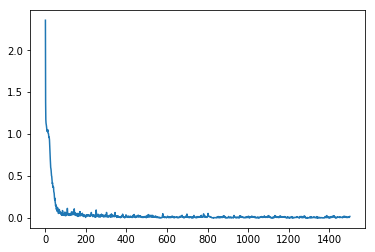

In [7]:
#plot loss
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss)

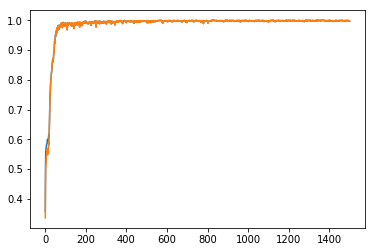

In [8]:
#plot accuracy and f1
acc = history.history['acc']
f1 = history.history['f1']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc)
plt.plot(epochs,f1)

In [9]:
from sklearn import metrics
#training and dev prediction
y_hat_train = model.predict(X_train)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_train, y_hat_train)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_train, y_hat_train,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_train, y_hat_train))

3824/3824 [==============================] - 6s 2ms/step
accuracy:   0.999
classification report:
             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00      2353
         AF       0.99      1.00      1.00       319
      Other       1.00      1.00      1.00      1072
      Noise       1.00      1.00      1.00        80

avg / total       1.00      1.00      1.00      3824

confusion matrix:
[[2351    2    0    0]
 [   0  319    0    0]
 [   0    0 1072    0]
 [   0    0    0   80]]


In [10]:
from sklearn import metrics
#training and dev prediction
y_hat_dev = model.predict(X_dev)

target_names = ['Normal','AF','Other','Noise']



score = metrics.accuracy_score(y_dev, y_hat_dev)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_dev, y_hat_dev,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_dev, y_hat_dev))

957/957 [==============================] - 2s 2ms/step
accuracy:   0.552
classification report:
             precision    recall  f1-score   support

     Normal       0.63      0.79      0.70       589
         AF       0.12      0.04      0.06        80
      Other       0.31      0.21      0.25       268
      Noise       0.11      0.05      0.07        20

avg / total       0.49      0.55      0.51       957

confusion matrix:
[[468  15 101   5]
 [ 57   3  20   0]
 [203   6  56   3]
 [ 17   0   2   1]]
